In [61]:
%matplotlib inline
from IPython.core.pylabtools import figsize

from functools import partial
import itertools
import re

import matplotlib.gridspec as gridspec
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd
import seaborn as sns

print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

import sklearn as sk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import column_or_1d
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union


from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction import DictVectorizer

import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs

import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn_pandas import DataFrameMapper, cross_val_score

import matplotlib.pyplot as plt
import patsy
from statsmodels.sandbox import cox

from patsylearn import *


Automatically created module for IPython interactive environment


## UTILS

In [2]:
def merge_dicts(*dict_args):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [3]:
def flatten_columns(df, prefix=''):
    return [prefix + '_'.join(t) for t in df.columns]

In [4]:
def get_agg(grpby_columns, grp_columns, grouping):    
    col_prefix = '_'.join(grpby_columns)    
    gr_aggs = lambda pref,grps:  {'_'.join((pref ,gr[0])):gr[1] for gr in grps.iteritems()}
    agg = {gc:gr_aggs(col_prefix, grouping) for gc in grp_columns}
    return agg

In [5]:
def columns_to_type(df, columns, totype):
    for col in columns:
        df[col] = df[col].astype(totype)

In [128]:
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
from scipy import interp

def run_crossval(X,y, fitter):
    
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    skf_cv = StratifiedKFold(y, n_folds=5) #n_folds=6
#     classifier = svm.Lo(kernel='linear', probability=True,random_state=random_state)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(skf_cv):
        model = fitter.fit(X.ix[train], y.ix[train])
        probas_ = model.predict_proba(X.ix[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(skf_cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return mean_auc

## LOAD DATA

In [6]:
main_folder = '/ea/Datasets/Kaggle-AcquireValuedShoppersChallenge2/'
df_coupons = pd.read_csv(main_folder+'offers')[['offer','category','company','brand','offervalue','quantity']]
df_offers_ids = pd.read_csv(main_folder+'trainHistory').rename(columns={'id': 'customer_id'})
df_trans_all = pd.read_csv(main_folder+'transactions_reduced_customer_category').rename(columns={'id': 'customer_id'})

In [99]:
df_offers_all = pd.merge(df_offers_ids, df_coupons, on=['offer'])
df_offers_all = df_offers_all[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity','repeattrips','repeater']]
# df_offers.set_index('customer_id',inplace=True)

In [100]:
df_coupons.head()

,offer,category,company,brand,offervalue,quantity
0,1190530,9115,108500080,93904,5.00,1
1,1194044,9909,107127979,6732,1.00,1
2,1197502,3203,106414464,13474,0.75,1
3,1198271,5558,107120272,5072,1.50,1
4,1198272,5558,107120272,5072,1.50,1


In [101]:
df_offers_all.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [102]:
df_trans_all.head()

NameError: name 'df_trans_all' is not defined

/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


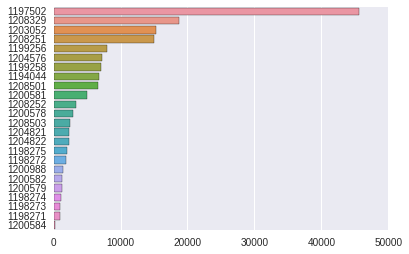

In [103]:
offer_counts = df_offers_all.groupby(by='offer').count().customer_id.order(ascending=False)
sns.barplot(y=offer_counts.index.values, x=offer_counts.values, orient='h')

## FILTER DATA

In [104]:
df_trans = df_trans_all#[0:3000000]

NameError: name 'df_trans_all' is not defined

In [1]:
df_offers = df_offers_all[df_offers_all.offer==1208503]

NameError: name 'df_offers_all' is not defined

In [110]:
len(df_trans.customer_id.unique()), len(df_trans.customer_id),  len(df_offers.customer_id.unique()),len(df_offers.customer_id), 

(159700, 8420912, 2413, 2413)

### SPLIT TRAIN-TEST

In [111]:
df_offers_train, df_offers_test = train_test_split(df_offers)
len(df_offers_train),len(df_offers_test)

(1809, 604)

## FEATURE EXTRACTION

### AGGREGATE TRANSCATIONS

In [20]:
summ_grouping = {'total':np.sum, 'average':np.average }
count_grouping = {'count':np.count_nonzero }

In [21]:
count_agg = partial(get_agg, grp_columns=['customer_id'], grouping=count_grouping)
total_avg_agg = partial(get_agg, grp_columns=['productsize','purchasequantity','purchaseamount'], grouping=summ_grouping)

In [22]:
grpby_columns = ['customer_id','brand']

df_trans_grp_customer_brand = df_trans.groupby(by=grpby_columns, axis=0) \
                               .agg(merge_dicts(count_agg(grpby_columns), \
                                                total_avg_agg(grpby_columns)))    
    
df_trans_grp_customer_brand.columns = flatten_columns(df_trans_grp_customer_brand,prefix='agg_')
df_trans_grp_customer_brand = df_trans_grp_customer_brand.reset_index()#.set_index('customer_id')
df_trans_grp_customer_brand.head()


,customer_id,brand,agg_productsize_customer_id_brand_average,agg_productsize_customer_id_brand_total,agg_customer_id_customer_id_brand_count,agg_purchaseamount_customer_id_brand_average,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total
0,86246,304,12,36,3,5.156667,15.47,1.000000,3
1,86246,305,6,18,3,1.650000,4.95,1.666667,5
2,86246,330,20,60,3,1.923333,5.77,1.000000,3
3,86246,401,50,50,1,6.590000,6.59,1.000000,1
4,86246,867,44,220,5,1.728000,8.64,1.200000,6


In [23]:
print len(df_trans_grp_customer_brand.brand.unique())
print len(df_trans_grp_customer_brand)

1689
2220514


In [24]:
grpby_columns = ['customer_id','category']
grp_columns = ['purchaseamount']

df_trans_grp_customer_category = df_trans.groupby(by=grpby_columns, axis=0) \
                                         .agg(merge_dicts(count_agg(grpby_columns), \
                                              total_avg_agg(grpby_columns))) 
    
df_trans_grp_customer_category.columns = flatten_columns(df_trans_grp_customer_category, prefix='agg_')
df_trans_grp_customer_category = df_trans_grp_customer_category.reset_index()#.set_index('customer_id')
df_trans_grp_customer_category.head()



,customer_id,category,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,86246,706,441.0,49.000000,9,37.38,4.153333,10,1.111111
1,86246,1703,470.5,31.366667,15,57.64,3.842667,18,1.200000
2,86246,1726,230.0,57.500000,4,12.18,3.045000,4,1.000000
3,86246,2119,1224.6,43.735714,28,63.66,2.273571,38,1.357143
4,86246,3203,79.0,5.266667,15,41.66,2.777333,15,1.000000


In [25]:
print len(df_trans_grp_customer_category)

1247483


In [26]:
grpby_columns = ['customer_id','dept']
grp_columns = ['productsize','purchaseamount']

df_trans_grp_customer_dept = df_trans.groupby(by=grpby_columns, axis=0) \
                                     .agg(merge_dicts(count_agg(grpby_columns), \
                                          total_avg_agg(grpby_columns))) 
    
df_trans_grp_customer_dept.columns = flatten_columns(df_trans_grp_customer_dept, prefix='agg_')
df_trans_grp_customer_dept = df_trans_grp_customer_dept.reset_index()#.set_index('customer_id')
df_trans_grp_customer_dept.head()

,customer_id,dept,agg_productsize_customer_id_dept_average,agg_productsize_customer_id_dept_total,agg_customer_id_customer_id_dept_count,agg_purchaseamount_customer_id_dept_average,agg_purchaseamount_customer_id_dept_total,agg_purchasequantity_customer_id_dept_average,agg_purchasequantity_customer_id_dept_total
0,86246,7,49.000000,441.00,9,4.153333,37.38,1.111111,10
1,86246,17,36.868421,700.50,19,3.674737,69.82,1.157895,22
2,86246,21,43.735714,1224.60,28,2.273571,63.66,1.357143,38
3,86246,32,5.266667,79.00,15,2.777333,41.66,1.000000,15
4,86246,35,39.182941,3996.66,102,3.289706,335.55,1.333333,136


### MERGE FEATURES TO ONE TABLE

In [112]:
print len(df_offers)
df_offers.head()

2413


,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
122523,203870922,96,1208503,27,6202,1087744888,64486,2013-04-24,1.5,1,0,f
122524,241826116,96,1208503,27,6202,1087744888,64486,2013-04-24,1.5,1,0,f
122525,241917653,96,1208503,27,6202,1087744888,64486,2013-04-27,1.5,1,0,f
122526,245103878,241,1208503,16,6202,1087744888,64486,2013-04-25,1.5,1,0,f
122527,245128847,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,1,t


In [113]:
df_offers_merge1 = df_offers.merge(df_trans_grp_customer_brand, how='inner', on=['customer_id','brand'])
df_offers_merge1.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater,agg_productsize_customer_id_brand_average,agg_productsize_customer_id_brand_total,agg_customer_id_customer_id_brand_count,agg_purchaseamount_customer_id_brand_average,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total
0,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,0,f,8.8,8.8,1,7.98,7.98,2,2
1,246201384,240,1208503,12,6202,1087744888,64486,2013-04-25,1.5,1,0,f,8.8,8.8,1,4.99,4.99,2,2
2,247178052,96,1208503,27,6202,1087744888,64486,2013-04-25,1.5,1,1,t,12.0,24.0,2,5.74,11.48,1,2
3,253934857,96,1208503,27,6202,1087744888,64486,2013-04-28,1.5,1,10,t,12.0,24.0,2,5.99,11.98,1,2
4,259885134,240,1208503,12,6202,1087744888,64486,2013-04-24,1.5,1,2,t,17.6,17.6,1,7.38,7.38,2,2


In [114]:
df_offers_merge2 = df_offers_merge1.merge(df_trans_grp_customer_category, how='inner', on=['customer_id', 'category'])
df_offers_merge2.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7.98,2,2,64.8,12.960000,5,37.83,7.566000,7,1.4
1,246201384,240,1208503,12,6202,1087744888,64486,2013-04-25,1.5,1,...,4.99,2,2,40.8,8.160000,5,47.40,9.480000,16,3.2
2,247178052,96,1208503,27,6202,1087744888,64486,2013-04-25,1.5,1,...,11.48,1,2,42.0,10.500000,4,22.46,5.615000,4,1.0
3,253934857,96,1208503,27,6202,1087744888,64486,2013-04-28,1.5,1,...,11.98,1,2,69.0,9.857143,7,37.53,5.361429,7,1.0
4,259885134,240,1208503,12,6202,1087744888,64486,2013-04-24,1.5,1,...,7.38,2,2,25.6,12.800000,2,12.67,6.335000,4,2.0


In [115]:
df_offers_merge3 = df_offers_merge2.merge(df_trans_grp_customer_dept, how='inner', on=['customer_id'])
df_offers_merge3.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average,dept,agg_productsize_customer_id_dept_average,agg_productsize_customer_id_dept_total,agg_customer_id_customer_id_dept_count,agg_purchaseamount_customer_id_dept_average,agg_purchaseamount_customer_id_dept_total,agg_purchasequantity_customer_id_dept_average,agg_purchasequantity_customer_id_dept_total
0,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7,1.4,21,32.00,192.0,6,2.933333,17.60,2.0,12
1,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7,1.4,58,19.00,19.0,1,5.290000,5.29,1.0,1
2,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7,1.4,62,12.96,64.8,5,7.566000,37.83,1.4,7
3,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7,1.4,72,4.00,4.0,1,3.000000,3.00,1.0,1
4,245998678,240,1208503,12,6202,1087744888,64486,2013-04-29,1.5,1,...,7,1.4,99,5.95,59.5,10,4.152000,41.52,1.5,15


In [116]:
df_offers_merge1[df_offers_merge1.isnull().any(axis=1)]

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater,agg_productsize_customer_id_brand_average,agg_productsize_customer_id_brand_total,agg_customer_id_customer_id_brand_count,agg_purchaseamount_customer_id_brand_average,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total


In [117]:
df_offers_merge2[df_offers_merge2.isnull().any(axis=1)]

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average


In [118]:
df_offers_merge3[df_offers_merge3.isnull().any(axis=1)]

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average,dept,agg_productsize_customer_id_dept_average,agg_productsize_customer_id_dept_total,agg_customer_id_customer_id_dept_count,agg_purchaseamount_customer_id_dept_average,agg_purchaseamount_customer_id_dept_total,agg_purchasequantity_customer_id_dept_average,agg_purchasequantity_customer_id_dept_total


### CLEAR MEMORY

In [34]:
%reset_selective -f df_trans_all

## TRAIN MODEL

In [119]:
df_data = df_offers_merge3

In [120]:
df_data.columns

Index([u'customer_id', u'chain', u'offer', u'market', u'category', u'company',
       u'brand', u'offerdate', u'offervalue', u'quantity', u'repeattrips',
       u'repeater', u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average', u'dept',
       u'agg_productsize_customer_id_dept_ave

In [121]:
categorical_cols = ['chain','market','category','company']
agg_cols = filter(lambda c: re.match("agg_*",c), df_data.columns)
num_cols = ['offervalue','quantity','repeattrips']

df_X = df_data.filter(items=categorical_cols+agg_cols+num_cols) 
df_Y = df_data[['repeater']]
Y = df_Y.repeater.map(lambda v: v=='t')

In [122]:
columns_to_type(df_X, categorical_cols, 'category')

In [123]:
len(categorical_cols+agg_cols), len(df_X.columns)

(25, 28)

In [124]:
len(df_X),len(df_Y)

(5627, 5627)

### BUILD PIPELINE

In [125]:
mapper = DataFrameMapper([
        (col, sk.preprocessing.LabelBinarizer()) for col in categorical_cols] 
      + [(agg_cols+num_cols, None)])

prepare_pipeline = make_pipeline(mapper,
                        PolynomialFeatures(degree=1, interaction_only=True),                         
                        preprocessing.StandardScaler()
                        ) 


In [126]:
fit_pipeline_LR1 = make_pipeline(prepare_pipeline,
                             lm.LogisticRegression(C=0.01, penalty='l1', fit_intercept=False))     

In [ ]:
patsy_transf = make_pipeline(PatsyTransformer("total_int_calls_minutes:C(intl_package, Treatment) + age -1", return_type='dataframe'))

### FIT DATA

In [56]:
df_X_transf = prepare_pipeline.fit_transform(df_X)


In [57]:
len(df_X_transf[1]),len(df_X_transf), len(Y)

(142, 13601, 13601)

In [58]:
fit_pipeline_LR1.fit(df_X, y=Y)
print 'score-train: ' + str(fit_pipeline_LR1.score(df_X, y=Y))

score-train: 0.717961914565


In [59]:
logreg = fit_pipeline_LR1.named_steps['logisticregression']
logreg.classes_
sum(logreg.coef_[0,:])

8.3510434332634365

In [78]:
scores = cv.cross_val_score(fit_pipeline_LR1, df_X, Y,cv=5, scoring='accuracy')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# X_test = prepare_pipeline.transform(X_test)
# print 'Test accuracy: %0.2f' % fit_pipeline.score(X_test, Y_test


[ 0.66115399  0.69227941  0.67279412  0.63639706  1.        ]
Accuracy: 0.73 (+/- 0.27)


### AUC

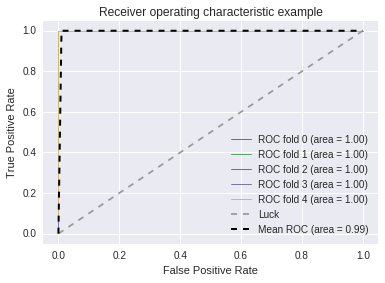

0.99494949494949503

In [129]:
run_crossval(df_X, Y, fit_pipeline_LR1)

## OTHER

In [ ]:
X =patsy.dmatrix('productsize_id_category_total:C(category, Treatment)  -1', data=df_trans_category_grp, return_type='dataframe')
X.head()

In [ ]:
X = patsy.dmatrix('market + category -1', data=df_off_hist_train, return_type='dataframe')
X.head()

In [ ]:
pd.DataFrame(df_trans_grp_brand.to_records())

In [ ]:
X = patsy.dmatrix('total_int_calls_minutes:C(intl_package, Treatment) + age -1', data=X_train, return_type='dataframe')

In [ ]:
df_offers_history[df_offers_history.id==4638754711]

In [ ]:
df_off_hist_train['id_chain'] =  df_off_hist_train['id'].map(lambda x:(str(x)+'_')) + df_off_hist_train['chain'].map(str)